This script performs the Pitzer fit method and shows the parity plots for each of the species. This code requires that the elementz.xml file in the data folder has been copied into Cantera's data folder. 

# Fitting Pitzer and linear parameters to single component data

In [5]:
from llepe import LLEPE, lmse_perturbed_obj, ind_lmse_perturbed_obj
import numpy as np
import itertools
import pandas as pd
import matplotlib
from scipy.optimize import curve_fit
import matplotlib
import matplotlib.pyplot as plt
import json

font = {'family': 'sans serif',
        'size': 24}
matplotlib.rc('font', **font)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rcParams['lines.linewidth'] = 4
matplotlib.rcParams['lines.markersize'] = 10

In [2]:
def linear(x, a, b):
    return a * x + b
lp_dict = {'species': [],
           'slope': [],
           'intercept': []}
species_list = 'Nd,Pr,Ce,La,Dy,Sm,Y'.split(',')
pitzer_params = pd.read_csv("../../data/csvs/may_pitzer_params.csv")
x_guesses = [[-5178500.0, -1459500.0],
             [-5178342.857142857, -1460300.0],
             [-5178342.857142857, -1459500.0],
             [-5178342.857142857, -1458300.0],
             [-5178185.714285715, -1459900.0],
             [-5178185.714285715, -1459500.0],
             [-5178185.714285715, -1459100.0],
             [-5178185.714285715, -1458300.0],
             [-5178028.571428572, -1459900.0],
             [-5178028.571428572, -1459100.0],
             [-5178028.571428572, -1458300.0],
             [-5177557.142857143, -1459900.0],
             [-5177400.0, -1460300.0]]
optimizer = 'scipy_minimize'
opt_dfs = {}
pitzer_params_dict = {}
for species in species_list:
    print(species)
    lower_species = species.lower()

    labeled_data = pd.read_csv("../../data/csvs/labeled_zeroes_removed_{0}.csv".format(lower_species))
    exp_data = labeled_data.drop(labeled_data.columns[0], axis=1)
    xml_file = '../../data/xmls/PC88A_HCL_{0}_w_pitzer.xml'.format(species)
    opt_values = {
        '(HA)2(org)_h0': [],
        '{0}(H(A)2)3(org)_h0'.format(species): [],
        'beta0': [],
        'beta1': [],
        'Cphi': [],
        'obj_value': [],
        'guess': []}
    new_x_guesses = []
    for x_guess in x_guesses:
        opt_dict = {'(HA)2(org)_h0': {'upper_element_name': 'species',
                                      'upper_attrib_name': 'name',
                                      'upper_attrib_value': '(HA)2(org)',
                                      'lower_element_name': 'h0',
                                      'lower_attrib_name': None,
                                      'lower_attrib_value': None,
                                      'input_format': '{0}',
                                      'input_value': x_guess[1]},
                    '{0}(H(A)2)3(org)_h0'.format(species): {
                        'upper_element_name': 'species',
                        'upper_attrib_name': 'name',
                        'upper_attrib_value': '{0}(H(A)2)3(org)'.format(
                            species),
                        'lower_element_name': 'h0',
                        'lower_attrib_name': None,
                        'lower_attrib_value': None,
                        'input_format': '{0}',
                        'input_value': x_guess[0]},
                    }
        pitzer_param_list = ['beta0', 'beta1', 'Cphi']
        for pitzer_param in pitzer_param_list:
            inner_dict = {'upper_element_name': 'binarySaltParameters',
                          'upper_attrib_name': 'cation',
                          'upper_attrib_value': '{0}+++'.format(species),
                          'lower_element_name': pitzer_param,
                          'lower_attrib_name': None,
                          'lower_attrib_value': None}
            pitzer_row = pitzer_params[
                pitzer_params['species'] == species]

            inner_dict2 = {'input_format': ' {0}, 0.0, 0.0, 0.0, 0.0 ',
                           'input_value': pitzer_row[pitzer_param].values[
                               0]}
            inner_dict.update(inner_dict2)
            opt_dict['{0}_{1}'.format(species, pitzer_param)] = inner_dict

        reeps_params = {
            'exp_data': exp_data,
            'phases_xml_filename': xml_file,
            'opt_dict': opt_dict,
            'phase_names': ['HCl_electrolyte', 'PC88A_liquid'],
            'aq_solvent_name': 'H2O(L)',
            'extractant_name': '(HA)2(org)',
            'diluant_name': 'dodecane',
            'complex_names': ['{0}(H(A)2)3(org)'.format(species)],
            'extracted_species_ion_names': ['{0}+++'.format(species)],
            'aq_solvent_rho': 1000.0,
            'extractant_rho': 960.0,
            'diluant_rho': 750.0,
            'objective_function': lmse_perturbed_obj,
            'optimizer': optimizer
        }
        estimator = LLEPE(**reeps_params)
        estimator.update_xml(reeps_params['opt_dict'])
        exp_df = estimator.get_exp_df()
        pred_dict = estimator.get_predicted_dict()
        init_obj_value = lmse_perturbed_obj(pred_dict, exp_df, [species], 1e-100)
        
        obj_kwargs = {'species_list': [species], 'epsilon': 1e-100}
        bounds = [(1e-1, 1e1)] * len(opt_dict)
        optimizer_kwargs = {"method": 'l-bfgs-b',
                            "bounds": bounds}
        opt_dict, obj_value = estimator.fit(
            objective_kwargs=obj_kwargs,
            optimizer_kwargs=optimizer_kwargs)
        keys = list(opt_dict.keys())
        info1 = [opt_dict[key]['input_value'] for key in keys]
        info1.append(obj_value)
        info1.append(x_guess)
        if obj_value > init_obj_value*0.95:
            continue
        
        opt_values_keys = opt_values.keys()
        for ind, key in enumerate(opt_values_keys):
            opt_values[key].append(info1[ind])
        new_x_guesses.append(x_guess)
    x_guesses = new_x_guesses
    opt_df = pd.DataFrame(opt_values)
    opt_dfs[species] = opt_df
                                               
    p_opt, p_cov = curve_fit(linear,
                             opt_df['(HA)2(org)_h0'].values,
                             opt_df['{0}(H(A)2)3(org)_h0'.format(
                                 species)].values)
    slope, intercept = p_opt
    lp_dict['species'].append(species)
    lp_dict['slope'].append(slope)
    lp_dict['intercept'].append(intercept)
    min_h0_row = opt_df[opt_df['(HA)2(org)_h0'] == opt_df['(HA)2(org)_h0'].min()]
    for pitzer_param in pitzer_param_list:
        value = min_h0_row[pitzer_param].values[0]
        inner_dict = {'upper_element_name': 'binarySaltParameters',
                      'upper_attrib_name': 'cation',
                      'upper_attrib_value': '{0}+++'.format(species),
                      'lower_element_name': pitzer_param,
                      'lower_attrib_name': None,
                      'lower_attrib_value': None,
                     'input_format': ' {0}, 0.0, 0.0, 0.0, 0.0 ',
                       'input_value': value}
        pitzer_params_dict['{0}_{1}'.format(species, pitzer_param)] = inner_dict
lp_df = pd.DataFrame(lp_dict)


Nd
Pr
Ce
La
Dy
Sm
Y


# Fitting extractant enthalpy to combined single and multicomponent dataset

In [3]:
def ext_to_complex(h0, custom_objects_dict, species):
    linear_params = custom_objects_dict['lp_df']
    row = linear_params[linear_params['species'] == species]
    return row['slope'].values[0] * h0[0] + row['intercept'].values[0]

labeled_data = pd.read_csv("../../data/csvs/zeroes_removed_PC88A_HCL_NdPrCeLaDySmY.csv")
exp_data = labeled_data.drop(labeled_data.columns[0], axis=1)
xml_file = '../../data/xmls/PC88A_HCL_NdPrCeLaDySmY_w_pitzer.xml'
complex_names = ['{0}(H(A)2)3(org)'.format(species)
                 for species in species_list]
dependant_params_dict = {}
for species, complex_name in zip(species_list, complex_names):
    inner_dict = {'upper_element_name': 'species',
                  'upper_attrib_name': 'name',
                  'upper_attrib_value': complex_name,
                  'lower_element_name': 'h0',
                  'lower_attrib_name': None,
                  'lower_attrib_value': None,
                  'input_format': '{0}',
                  'function': ext_to_complex,
                  'kwargs': {"species": species},
                  'independent_params': '(HA)2(org)_h0'}
    dependant_params_dict['{0}_h0'.format(complex_name)] = inner_dict
extractant_guess = -1.37e6
info_dict = {'(HA)2(org)_h0': {'upper_element_name': 'species',
                              'upper_attrib_name': 'name',
                              'upper_attrib_value': '(HA)2(org)',
                              'lower_element_name': 'h0',
                              'lower_attrib_name': None,
                              'lower_attrib_value': None,
                              'input_format': '{0}',
                              'input_value': extractant_guess},
            }
reeps_params = {
    'exp_data': exp_data,
    'phases_xml_filename': xml_file,
    'opt_dict': info_dict,
    'phase_names': ['HCl_electrolyte', 'PC88A_liquid'],
    'aq_solvent_name': 'H2O(L)',
    'extractant_name': '(HA)2(org)',
    'diluant_name': 'dodecane',
    'complex_names': ['{0}(H(A)2)3(org)'.format(species)
                      for species in species_list],
    'extracted_species_ion_names': ['{0}+++'.format(species)
                                    for species in species_list],
    'aq_solvent_rho': 1000.0,
    'extractant_rho': 960.0,
    'diluant_rho': 750.0,
    'objective_function': lmse_perturbed_obj,
    'custom_objects_dict': {'lp_df': lp_df}
}
estimator = LLEPE(**reeps_params)
estimator.set_dependant_params_dict(dependant_params_dict)
estimator.update_xml(pitzer_params_dict)
estimator.update_xml(reeps_params['opt_dict'],
                     dependant_params_dict=dependant_params_dict)
obj_kwargs = {'species_list': species_list,
              'epsilon': 1e-100}
optimizer_kwargs = {"method": 'l-bfgs-b',
                    "bounds": [(1e-1, 1e1)] * len(info_dict)}
opt_dict, obj_value = estimator.fit(
    objective_kwargs=obj_kwargs,
    optimizer_kwargs=optimizer_kwargs)
estimator.update_xml(opt_dict,
                     dependant_params_dict=dependant_params_dict)

c:\users\tq220\documents\tits things\anl research\gitlab\parameter-estimation\llepe\llepe.py:988: RuntimeWarning: invalid value encountered in true_divide
  d_array = extracted_species_org_array / extracted_species_aq_array


# Plotting organic phase parity plots for complete unfiltered dataset 

c:\users\tq220\documents\tits things\anl research\gitlab\parameter-estimation\llepe\llepe.py:988: RuntimeWarning: invalid value encountered in true_divide
  d_array = extracted_species_org_array / extracted_species_aq_array


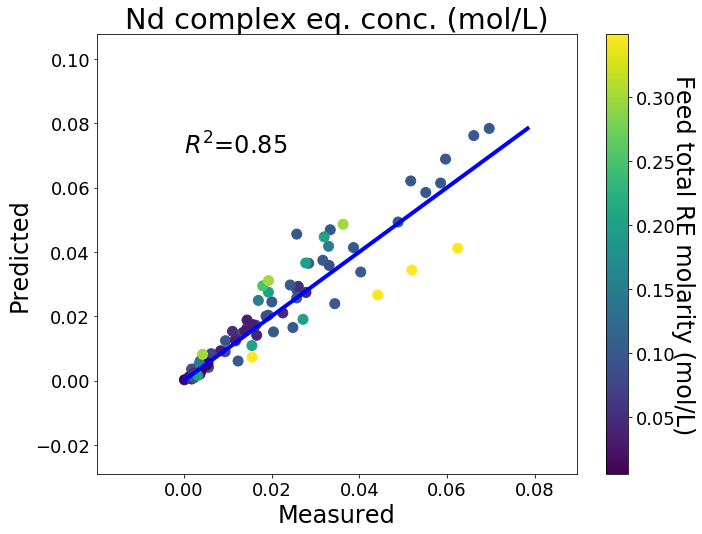

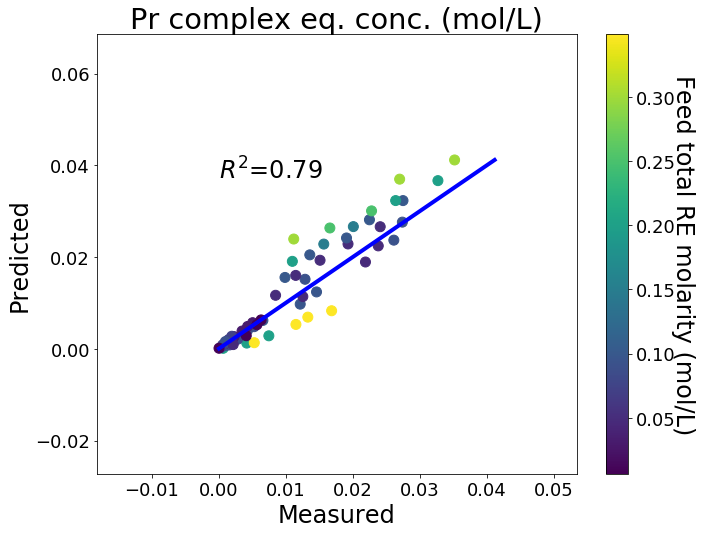

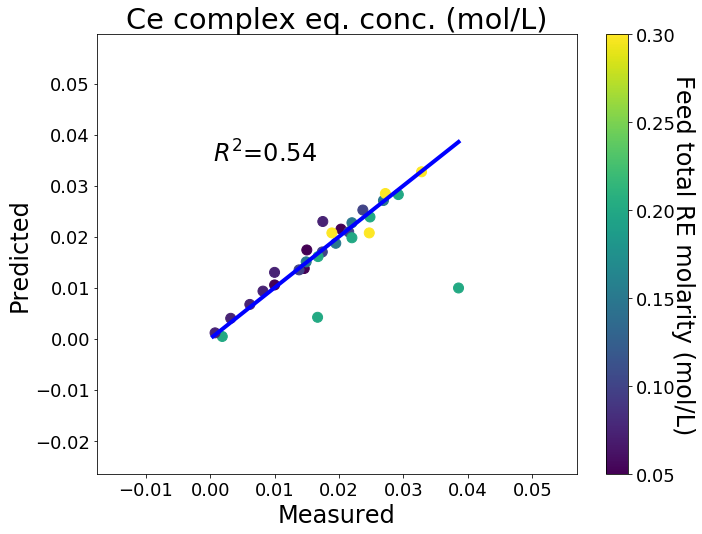

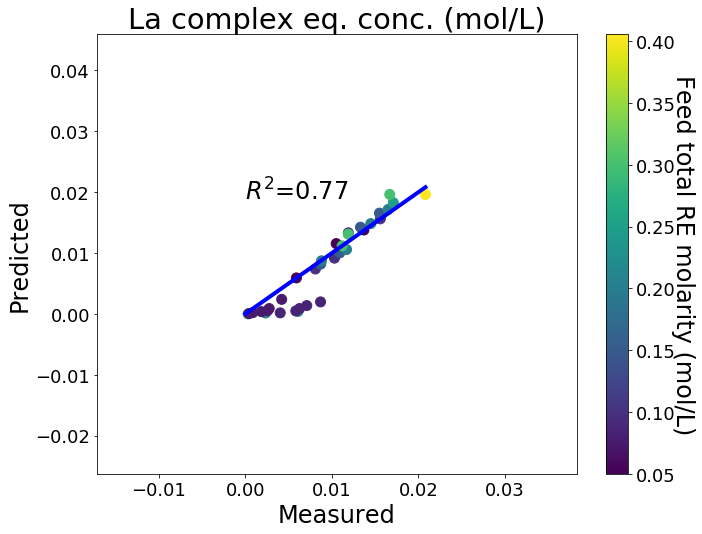

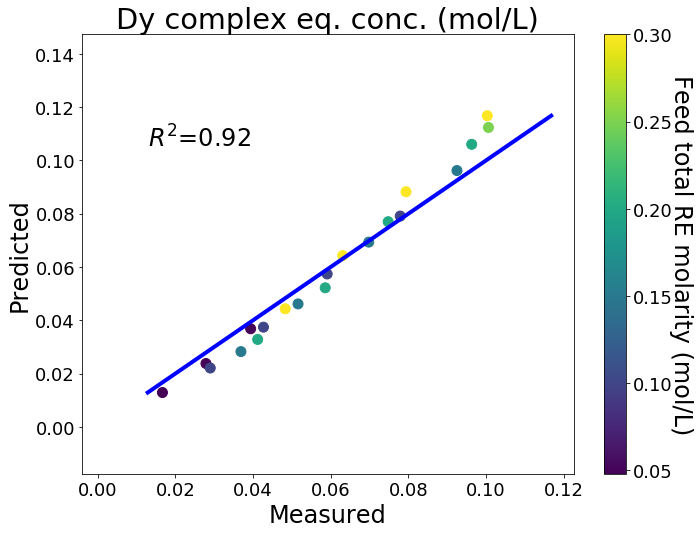

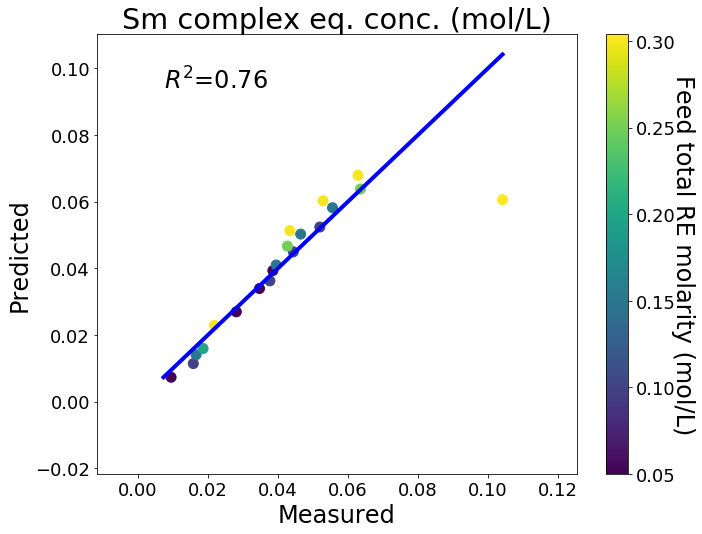

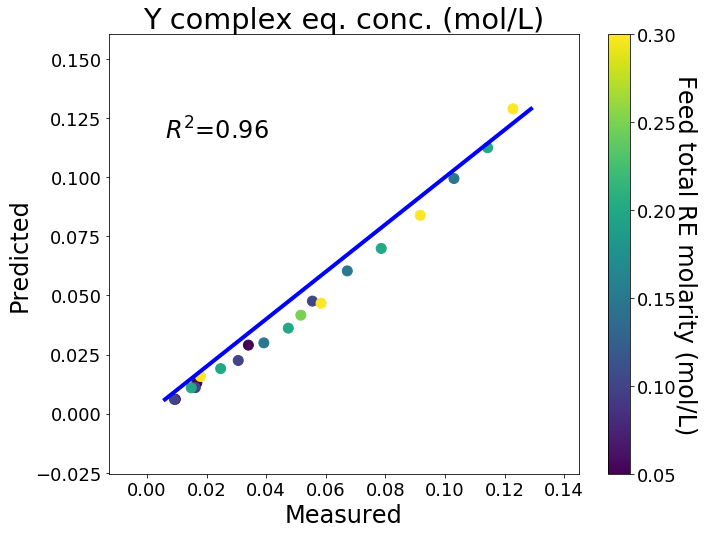

In [11]:

feed_cols = []
labeled_complete_data = pd.read_csv("../../data/csvs/PC88A_HCL_NdPrCeLaDySmY.csv")
complete_exp_df = labeled_data.drop(labeled_data.columns[0], axis=1)
estimator.set_exp_df(complete_exp_df)
exp_data = estimator.get_exp_df()
for col in exp_data.columns:
    if 'aq_i' in col:
        feed_cols.append(col)
exp_data['total_re'] = exp_data[feed_cols].sum(axis=1)
for species in species_list:
    fig, ax = estimator.parity_plot('{0}_org_eq'.format(species),
                                    c_data=
                                    exp_data['total_re'].values,
                                    c_label='Feed total RE '
                                            'molarity (mol/L)',
                                    print_r_squared=True)